# Model 2: Bayesian Neural Network

### Quantifying uncertainty to improve prediction accuracy 

This model will be built using **only** beatAML data to predict AUC, however, this time we will use a bayesian neural network. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pickle
from torch.utils import data
from matplotlib import pyplot as plt
import pandas as pd
import imageio

import torchvision
from torchvision import datasets, transforms
from matplotlib import colors
from IPython import display

import pyro
from pyro.distributions import Normal, Categorical, Uniform
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# Utilities 

In [2]:
# plot and show learning process
#from : https://medium.com/@benjamin.phillips22/simple-regression-with-neural-networks-in-pytorch-313f06910379

def plot_learning_process(axes, tr_ys, tr_yhats, tst_ys, tst_yhats, epoch, tr_loss, tst_loss):

    axes[0].cla()
    
    ######### TRAIN #########
    tr_df = pd.DataFrame({'y':tr_ys, 'yhat':tr_yhats})
    tr_df.sort_values(by='y', inplace=True)
    
    axes[0].plot(tr_df.values[:,0], 'ro', label='true', alpha=0.5)
    axes[0].plot(tr_df.values[:,1], 'bo', label='predicted', alpha=0.5)
    #plt.legend()
    
    axes[0].set_title('Regression Analysis [Training Set]', fontsize=15)
    axes[0].set_xlabel('Sorted observations', fontsize=24)
    axes[0].set_ylabel('AUC', fontsize=24)

    axes[0].text(100, 30, 'Epoch = %d' % epoch, fontdict={'size': 24, 'color':  'red'})
    axes[0].text(100, 50, 'Loss = %.4f' % loss, fontdict={'size': 24, 'color':  'red'})

    ######### TEST #########
    
    axes[1].cla()
    
    tst_df = pd.DataFrame({'y':tst_ys, 'yhat':tst_yhats})
    tst_df.sort_values(by='y', inplace=True)
    
    axes[1].plot(tst_df.values[:,0], 'ro', label='true', alpha=0.5)
    axes[1].plot(tst_df.values[:,1], 'bo', label='predicted', alpha=0.5)
    plt.legend()
    
    axes[1].set_title('Regression Analysis [Validation Set]', fontsize=15)
    axes[1].set_xlabel('Sorted observations', fontsize=24)
    axes[1].set_ylabel('AUC', fontsize=24)

    axes[1].text(100, 30, 'Epoch = %d' % epoch, fontdict={'size': 24, 'color':  'red'})
    axes[1].text(100, 50, 'Loss = %.4f' % loss, fontdict={'size': 24, 'color':  'red'})

    ######## DA REST #############
    
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

class saver_and_early_stopping: 
    '''
    '''
    def __init__(self, max_epoch, lr, do, arch, wd, name='FCNN-AML', early_stop_patience = 10, save_path='../data_pytorch/'):
        ''''''
        self.lr = lr
        self.do = do
        self.arch = arch
        self.wd = wd 
        self.name = name 
        self.loss = np.inf 
        self.ii = 0
        self.patience = early_stop_patience
        self.max_epoch = max_epoch
        
        if not os.path.exists(save_path + 'model_' + name):
            os.mkdir(save_path + 'model_' + name)
            
        self.fpath = save_path + 'model_' + name
        
    def update(self, loss, epoch, model):
        '''
        '''
        if epoch == (self.max_epoch - 1):
            torch.save(model.state_dict(), self.fpath + f'/loss={self.loss:.2f}_epoch={epoch}_lr={self.lr}_do={self.do}_arch={self.arch}_wd={self.wd}.pt')
            self.fname = self.fpath + f'/loss={self.loss}_epoch={epoch}_lr={self.lr}_do={self.do}_arch={self.arch}_wd={self.wd}'
            return True
        if self.ii > self.patience: 
            torch.save(model.state_dict(), self.fpath + f'/loss={self.loss:.2f}_epoch={epoch}_lr={self.lr}_do={self.do}_arch={self.arch}_wd={self.wd}.pt')
            self.fname = self.fpath + f'/loss={self.loss}_epoch={epoch}_lr={self.lr}_do={self.do}_arch={self.arch}_wd={self.wd}'
            return False
        if loss < self.loss: 
            self.loss = loss 
            self.ii = 0
        else:
            self.ii += 1
        return True
    
    def get_fname(self): 
        ''''''
        return self.fname

# Define our Dataset Class 

In [3]:
class DrugExpressionDataset(Dataset): 
    '''
    '''
    def __init__ (self, label_dict, root_dir='../data_pytorch/tensors'): 
        '''
        '''
        self.index = list(label_dict.keys())
        self.labels = label_dict
        self.root = root_dir
                            
    def __len__(self):
        '''
        '''
        return len(self.labels.keys())
        
    def __getitem__(self, index, response_type=False):
        '''
        '''
        fid = self.index[index]
        X = torch.load(f'{self.root}/{fid}.pt') #<----------------------------- number of genes to use
        _id, id_type, resp_type, response = self.labels[fid]
        
        if response_type: 
            return X, (response, resp_type)
        else: 
            return X, response

# Separate data into train/test/validate 

In [4]:
train, test, val = (0.65,0.2,0.15)

with open('../data_pytorch/label_dict.pkl', 'rb') as f: 
    label_dict = pickle.load(f)

label_dict2 = dict()
for fid in label_dict: 
    _id, id_type, resp_type, response = label_dict[fid]
    
    if resp_type not in label_dict2: 
        label_dict2[resp_type] = dict()
        
    p = np.random.rand()
    if (p < train): # add to training set 
        if 'train' in label_dict2[resp_type]: 
            label_dict2[resp_type]['train'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['train'] = {fid:(_id, id_type, resp_type, response)}

    elif (p < train+test): # add to test set 
        if 'test' in label_dict2[resp_type]: 
            label_dict2[resp_type]['test'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['test'] = {fid:(_id, id_type, resp_type, response)}
    else: # add to validation set 
        if 'val' in label_dict2[resp_type]: 
            label_dict2[resp_type]['val'][fid] = (_id, id_type, resp_type, response)
        else:
            label_dict2[resp_type]['val'] = {fid:(_id, id_type, resp_type, response)}            

In [5]:
label_dict2.keys()

dict_keys(['RNAi_dependency', 'crispr_dependency', 'pooled_drugresp_prism', 'AUC_GDSC', 'CTRP_AUC', 'AUC_drug_CCLE', 'beatAML_AUC'])

In [6]:
for resp_type in label_dict2:
    for sset in label_dict2[resp_type]: 
        pp = resp_type + ' '*(20 - len(resp_type))
        print(f'set sizes: {pp} \t-> {sset}  \t-> {len(label_dict2[resp_type][sset])}')

set sizes: RNAi_dependency      	-> train  	-> 186006
set sizes: RNAi_dependency      	-> test  	-> 57386
set sizes: RNAi_dependency      	-> val  	-> 43147
set sizes: crispr_dependency    	-> train  	-> 201481
set sizes: crispr_dependency    	-> val  	-> 46868
set sizes: crispr_dependency    	-> test  	-> 62619
set sizes: pooled_drugresp_prism 	-> train  	-> 99089
set sizes: pooled_drugresp_prism 	-> test  	-> 30317
set sizes: pooled_drugresp_prism 	-> val  	-> 23021
set sizes: AUC_GDSC             	-> train  	-> 10863
set sizes: AUC_GDSC             	-> test  	-> 3308
set sizes: AUC_GDSC             	-> val  	-> 2493
set sizes: CTRP_AUC             	-> train  	-> 17970
set sizes: CTRP_AUC             	-> test  	-> 5566
set sizes: CTRP_AUC             	-> val  	-> 4094
set sizes: AUC_drug_CCLE        	-> train  	-> 1444
set sizes: AUC_drug_CCLE        	-> val  	-> 334
set sizes: AUC_drug_CCLE        	-> test  	-> 505
set sizes: beatAML_AUC          	-> train  	-> 1123
set sizes: beatA

In [7]:
max(label_dict.keys())

798259

# Defining our model architecture 

Going to use a straight forward 4 layer FFFC network. 

In [8]:
class BNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(BNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = x.reshape(x.size(0), -1)
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [9]:
log_softmax = nn.LogSoftmax(dim=1)
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    mean = lifted_reg_model(x_data)
    sigma = pyro.sample("sigma", Uniform(0., 10.))
    
    pyro.sample("obs", Normal(mean, sigma), obs=y_data)

In [10]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

# Initialize our model and DataLoader(s)

In [29]:
LEARNING_WEIGHT = 1e-1
EPOCHS = 10
NGENES = 523 #/523

# Reproducibility
#torch.manual_seed(2)
#np.random.seed(2)

In [30]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [31]:
net = BNN(NGENES*2, 2000, 1)


In [32]:
# Parameters
params = {'batch_size': 128*4,
          'shuffle': True,
          'num_workers': 0}

train_set = DrugExpressionDataset(label_dict2['beatAML_AUC']['train'])
test_set = DrugExpressionDataset(label_dict2['beatAML_AUC']['test'])
val_set = DrugExpressionDataset(label_dict2['beatAML_AUC']['val'])

train_gen = data.DataLoader(train_set, **params)
test_gen = data.DataLoader(test_set, **params)
val_gen = data.DataLoader(val_set, **params)

In [33]:
optim = pyro.optim.Adam({"lr": LEARNING_WEIGHT})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

# Train our model

In [34]:
recorder={'train':{'total_loss':[], 'mse':[]}}

for epoch in range(EPOCHS):
    net.train()
    total_loss = 0
    elbo = 0
    for X,y in train_gen:
        y = y.unsqueeze(1)
        X,y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
        loss = svi.step(X, y)
        total_loss += loss
        
    recorder['train']['total_loss'].append(total_loss)
    recorder['train']['mse'].append(total_loss/len(train_gen.dataset))

    print(f'epoch {epoch+1}/{EPOCHS} \t|\t train total loss: {total_loss:.2f} \t train elbo: {total_loss/len(train_gen.dataset):.2f} \t', end='\r')


### visualize training 

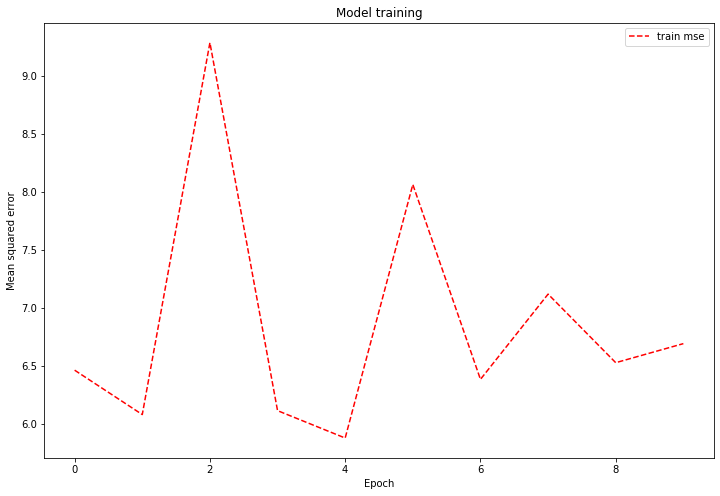

In [35]:
plt.figure(figsize=(12,8))
plt.plot(np.log10(recorder['train']['mse']), 'r--', label='train mse')
plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('Model training')
plt.legend()
plt.show()

# Test our model

In [ ]:
net.eval()
test_total_loss = 0
yhats = []
ys = []
for X, y in test_gen:
    X,y = X.to(device, dtype=torch.float), y.to(device, dtype=torch.float)
    y = y.unsqueeze(1)
    yhat = net.forward(X)
    test_total_loss += loss_func(yhat, y).detach().numpy()
    yhats += yhat.data.numpy().ravel().tolist()
    ys += y.data.numpy().ravel().tolist()

net.train()

print(f'test mse: {test_total_loss/len(test_gen.dataset)}')

In [ ]:
df = pd.DataFrame({'y':ys, 'yhat':yhats}).assign(diff = lambda x: np.max(x.y) * (x.y-x.yhat)**2 / np.max((x.y-x.yhat)**2))

df.sort_values(by='y', inplace=True)

df = df.assign(diff_rm = df['diff'].rolling(window=10).mean())

plt.figure(figsize=(12,8))
plt.plot(df['y'].values, 'ro', label='y [true]')
plt.plot(df['yhat'].values, 'bo', label='yhat [predicted]')
plt.plot(df['diff_rm'].values, 'g--', label='scaled rolling mean quadratic error')
plt.xlabel('Sorted Observations')
plt.ylabel('Area Under the Curve (AUC)')
plt.title(f'BeatAML FCNN Test Set Predictions [n={len(test_gen.dataset)}]')
plt.legend()
plt.show()
